**YOLOv2 (YOLO9000)**


In [2]:
!pip install numpy pillow torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
import torch.nn as nn
import numpy as np

class YoloV2Net(nn.Module):
    def __init__(self, num_anchors=5, num_classes=80):
        """Initialize YOLOv2 network with Darknet-19 backbone."""
        super(YoloV2Net, self).__init__()
        self.num_classes = num_classes  # 80 classes for COCO
        self.anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843,
                        5.47434, 7.88882, 3.52778, 9.77052, 9.16888]  # Precomputed anchors
        self.num_anchors = num_anchors
        self.darknet = Darknet()  # Darknet-19 backbone

        # Process 13x13x1024 feature map from Darknet
        self.conv1 = nn.Sequential(
            Conv2D(1024, 1024, 3),
            Conv2D(1024, 1024, 3))

        # Process 26x26x512 feature map for passthrough
        self.conv2 = nn.Sequential(
            Conv2D(512, 64, 1))

        # Combine features and produce output (5 anchors * (5 + 80) = 425 channels)
        self.conv = nn.Sequential(
            Conv2D(1280, 1024, 3),
            nn.Conv2d(1024, self.num_anchors * (self.num_classes + 5), 1))

    def forward(self, x):
        """Forward pass: Input (416x416x3) -> Output (13x13x425)."""
        x1, x2 = self.darknet(x)  # x1: 13x13x1024, x2: 26x26x512
        x1 = self.conv1(x1)  # Refine x1
        x2 = self.conv2(x2)  # Reduce channels of x2
        x2 = Reorg(x2)  # Reorganize x2 to 13x13x256
        x = torch.cat([x2, x1], 1)  # Concatenate: 13x13x1280
        x = self.conv(x)  # Final output
        return x

def load_weights(model, wt_file):
    """Load weights from .weights file into the model."""
    buf = np.fromfile(wt_file, dtype=np.float32)
    start = 4  # Skip header

    # Load weights for Darknet-19 layers
    for i in range(13):
        bn = model.darknet.main1[i].bn
        conv = model.darknet.main1[i].conv
        start = load_conv_bn(buf, start, conv, bn)
    for i in range(1, 6):
        bn = model.darknet.main2[i].bn
        conv = model.darknet.main2[i].conv
        start = load_conv_bn(buf, start, conv, bn)

    # Load weights for additional conv layers
    for i in range(2):
        start = load_conv_bn(buf, start, model.conv1[i].conv, model.conv1[i].bn)
    start = load_conv_bn(buf, start, model.conv2[0].conv, model.conv2[0].bn)
    start = load_conv_bn(buf, start, model.conv[0].conv, model.conv[0].bn)
    start = load_conv(buf, start, model.conv[1])

def load_model(weights, device):
    """Load YOLOv2 model and its weights, move to device."""
    model = YoloV2Net()
    if weights:
        load_weights(model, weights)  # Load pre-trained weights
    return model.to(device)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def load_conv_bn(buf, start, conv_model, bn_model):
    """Load weights for conv and batch norm layers from buffer."""
    num_w = conv_model.weight.numel()  # Number of weights in conv layer
    num_b = bn_model.bias.numel()  # Number of biases in batch norm
    # Load batch norm biases, weights, running mean, and variance
    bn_model.bias.data.copy_(torch.from_numpy(buf[start: start + num_b])); start = start + num_b
    bn_model.weight.data.copy_(torch.from_numpy(buf[start: start + num_b])); start = start + num_b
    bn_model.running_mean.copy_(torch.from_numpy(buf[start: start + num_b])); start = start + num_b
    bn_model.running_var.copy_(torch.from_numpy(buf[start: start + num_b])); start = start + num_b
    # Load conv weights
    conv_model.weight.data.copy_(torch.from_numpy(buf[start: start + num_w]).reshape_as(conv_model.weight)); start = start + num_w
    return start

def load_conv(buf, start, conv_model):
    """Load weights for conv layer from buffer."""
    num_w = conv_model.weight.numel()  # Number of weights
    num_b = conv_model.bias.numel()  # Number of biases
    # Load conv biases and weights
    conv_model.bias.data.copy_(torch.from_numpy(buf[start: start + num_b])); start = start + num_b
    conv_model.weight.data.copy_(torch.from_numpy(buf[start: start + num_w]).reshape_as(conv_model.weight)); start = start + num_w

class Conv2D(nn.Module):
    """Custom layer: Conv2D + BatchNorm + LeakyReLU + optional MaxPool."""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=True, activation=True, pooling=False):
        super(Conv2D, self).__init__()
        padding = (kernel_size - 1) // 2 if padding else 0  # Calculate padding
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)  # Conv layer
        self.bn = nn.BatchNorm2d(out_channels)  # Batch norm
        self.relu = nn.LeakyReLU(0.1, inplace=True) if activation else lambda x: x  # LeakyReLU or identity
        self.pooling = pooling  # Flag for max pooling

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))  # Apply conv, batch norm, and activation
        return F.max_pool2d(x, 2, 2) if self.pooling else x  # Apply max pooling if enabled

def Reorg(x, s=2):
    """Reorganize feature map for passthrough layer (e.g., 26x26x512 -> 13x13x2048)."""
    B, C, H, W = x.size()  # Input dimensions
    h, w = H // s, W // s  # Downsampled dimensions
    # Reshape and transpose to group pixels
    x = x.view(B, C, h, s, w, s).transpose(3, 4).contiguous()
    x = x.view(B, C, h * w, s * s).transpose(2, 3).contiguous()
    x = x.view(B, C, s * s, h, w).transpose(1, 2).contiguous()
    return x.view(B, s * s * C, h, w)  # Output shape

class Darknet(nn.Module):
    """Darknet-19 backbone for YOLOv2 feature extraction."""
    def __init__(self):
        super(Darknet, self).__init__()
        # First block: Downsample input (3, 416, 416) to (512, 26, 26)
        self.main1 = nn.Sequential(
            Conv2D(3, 32, 3, pooling=True),  # 416x416 -> 208x208
            Conv2D(32, 64, 3, pooling=True),  # 208x208 -> 104x104
            Conv2D(64, 128, 3),
            Conv2D(128, 64, 1),
            Conv2D(64, 128, 3, pooling=True),  # 104x104 -> 52x52
            Conv2D(128, 256, 3),
            Conv2D(256, 128, 1),
            Conv2D(128, 256, 3, pooling=True),  # 52x52 -> 26x26
            Conv2D(256, 512, 3),
            Conv2D(512, 256, 1),
            Conv2D(256, 512, 3),
            Conv2D(512, 256, 1),
            Conv2D(256, 512, 3))  # Output: 26x26x512

        # Second block: Further downsample to (1024, 13, 13)
        self.main2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),  # 26x26 -> 13x13
            Conv2D(512, 1024, 3),
            Conv2D(1024, 512, 1),
            Conv2D(512, 1024, 3),
            Conv2D(1024, 512, 1),
            Conv2D(512, 1024, 3))  # Output: 13x13x1024

    def forward(self, x):
        x1 = self.main1(x)  # Intermediate output: 26x26x512
        x2 = self.main2(x1)  # Final output: 13x13x1024
        return x2, x1  # Return both for passthrough

Testing with zidane.jpg:
Using device: cuda
Result saved as 'output.jpg'


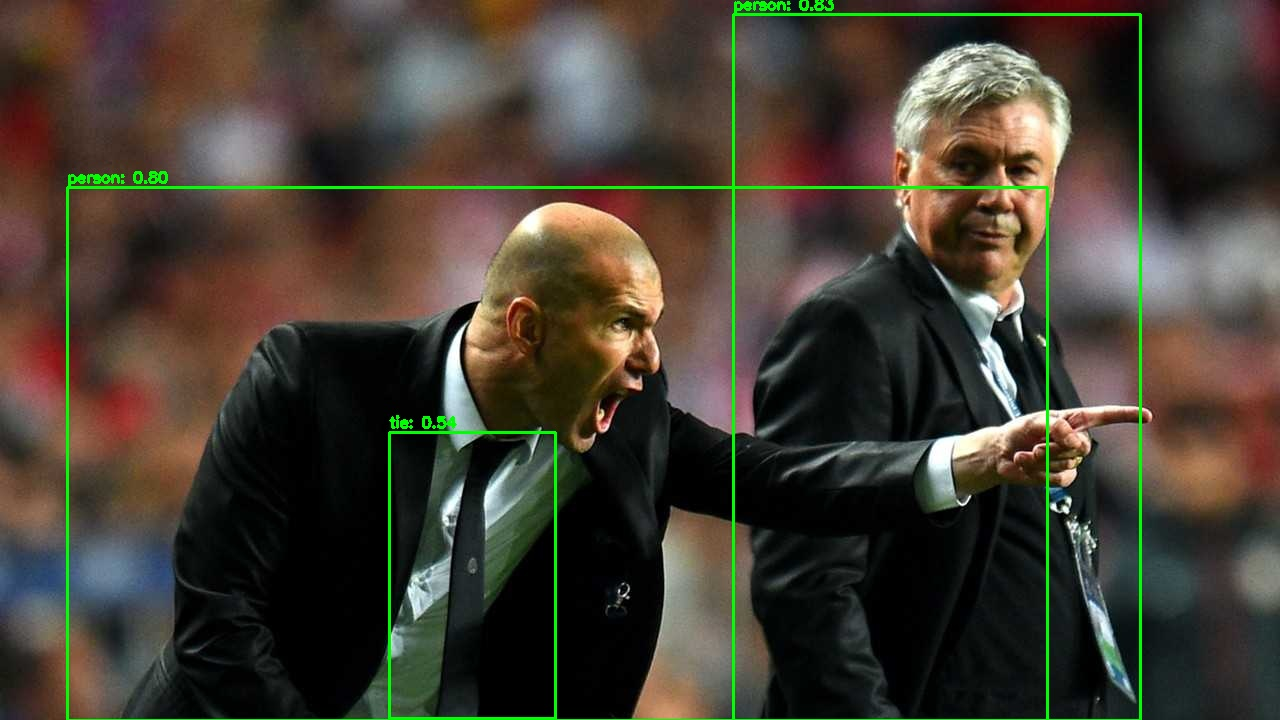


Testing with bus.jpg:
Using device: cuda
Result saved as 'output.jpg'


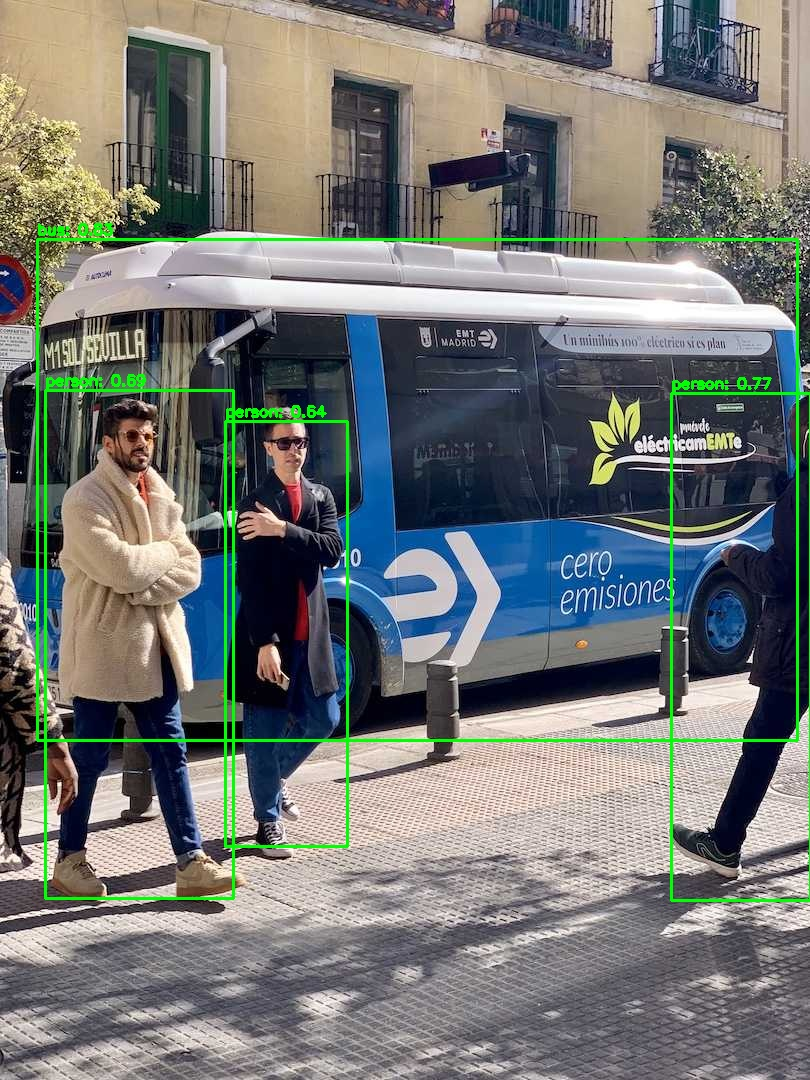

In [14]:
import cv2
import numpy as np
import torch
from IPython.display import Image, display

# Preprocessing function
def preprocess_image(image_path, input_size=416):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    image_resized = cv2.resize(image, (input_size, input_size))
    image_resized = image_resized / 255.0  # Normalize to [0, 1]
    image_resized = np.transpose(image_resized, (2, 0, 1))  # HWC to CHW
    image_tensor = torch.from_numpy(image_resized).float().unsqueeze(0)  # Add batch dimension
    return image_tensor, image, (h, w)

# Load COCO class names
def load_classes():
    classes = [
        "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
        "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
        "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
        "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball",
        "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
        "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
        "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
        "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
        "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]
    return classes

# post-processing function
def post_process(predictions, conf_thresh=0.5, nms_thresh=0.4, num_classes=80, num_anchors=5):
    batch_size, channels, grid_h, grid_w = predictions.size()
    predictions = predictions.view(batch_size, num_anchors, num_classes + 5, grid_h, grid_w)
    predictions = predictions.permute(0, 3, 4, 1, 2).contiguous()  # [B, H, W, A, C+5]

    # Extract coordinates, confidence, and class scores
    boxes = predictions[..., :4]  # x, y, w, h
    conf = torch.sigmoid(predictions[..., 4])  # Objectness score
    class_scores = torch.sigmoid(predictions[..., 5:])  # Class probabilities

    # Convert box coordinates from center to corners
    grid_x = torch.arange(grid_w).repeat(grid_h, 1).view([1, grid_h, grid_w, 1]).float().to(predictions.device)
    grid_y = torch.arange(grid_h).repeat(grid_w, 1).t().view([1, grid_h, grid_w, 1]).float().to(predictions.device)
    anchor_w = torch.tensor([0.57273, 1.87446, 3.33843, 7.88282, 9.77052]).to(predictions.device)
    anchor_h = torch.tensor([0.677385, 2.06253, 5.47434, 3.52778, 9.16828]).to(predictions.device)

    # Adjust coordinates to image space (416x416)
    boxes[..., 0] = (torch.sigmoid(boxes[..., 0]) + grid_x) * (416 / grid_w)  # x
    boxes[..., 1] = (torch.sigmoid(boxes[..., 1]) + grid_y) * (416 / grid_h)  # y
    boxes[..., 2] = torch.exp(boxes[..., 2]) * anchor_w.view(1, 1, 1, num_anchors) * (416 / grid_w)  # w
    boxes[..., 3] = torch.exp(boxes[..., 3]) * anchor_h.view(1, 1, 1, num_anchors) * (416 / grid_h)  # h

    # Convert to corner coordinates (x1, y1, x2, y2)
    boxes[..., 0], boxes[..., 2] = boxes[..., 0] - boxes[..., 2] / 2, boxes[..., 0] + boxes[..., 2] / 2
    boxes[..., 1], boxes[..., 3] = boxes[..., 1] - boxes[..., 3] / 2, boxes[..., 1] + boxes[..., 3] / 2

    # Flatten for NMS
    boxes = boxes.view(batch_size, -1, 4)
    conf = conf.view(batch_size, -1)
    class_scores = class_scores.view(batch_size, -1, num_classes)

    # Filter by confidence
    mask = conf > conf_thresh
    boxes = boxes[mask]
    conf = conf[mask]
    class_scores = class_scores[mask.unsqueeze(-1).expand_as(class_scores)].view(-1, num_classes)

    if boxes.size(0) == 0:
        return [], [], []

    # Apply NMS
    try:
        from torchvision.ops import nms
        nms_indices = nms(boxes, conf, nms_thresh)
    except:
        # Simple NMS fallback
        def simple_nms(boxes, scores, iou_threshold):
            order = scores.argsort(descending=True)
            keep = []
            while order.numel() > 0:
                i = order[0].item()
                keep.append(i)
                if order.numel() == 1:
                    break
                iou = box_iou(boxes[i].unsqueeze(0), boxes[order[1:]]).squeeze()
                mask = iou < iou_threshold
                order = order[1:][mask]
            return torch.tensor(keep, device=boxes.device)

        def box_iou(box1, box2):
            area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
            area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
            inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) -
                     torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
            union = area1[:, None] + area2 - inter
            return inter / union

        nms_indices = simple_nms(boxes, conf, nms_thresh)

    boxes = boxes[nms_indices]
    conf = conf[nms_indices]
    class_scores = class_scores[nms_indices]
    labels = torch.argmax(class_scores, dim=-1)

    return boxes, conf, labels

# draw_boxes function
def draw_boxes(image, boxes, scores, labels, classes, orig_size):
    h, w = orig_size
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        # Scale coordinates to original image size
        x1 = int(x1 * w / 416)
        y1 = int(y1 * h / 416)
        x2 = int(x2 * w / 416)
        y2 = int(y2 * h / 416)
        # Ensure coordinates are within image bounds
        x1, x2 = max(0, min(x1, w)), max(0, min(x2, w))
        y1, y2 = max(0, min(y1, h)), max(0, min(y2, h))
        label = classes[labels[i]]
        score = scores[i].item()
        color = (0, 255, 0)  # Green
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        text = f'{label}: {score:.2f}'
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image

# detect function
def detect(image_path='test.jpg', weights_path='yolov2.weights'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = load_model(weights_path, device)
    model.eval()

    image_tensor, orig_image, orig_size = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        predictions = model(image_tensor)

    boxes, scores, labels = post_process(predictions)

    classes = load_classes()
    result_image = draw_boxes(orig_image.copy(), boxes, scores, labels, classes, orig_size)

    cv2.imwrite('output.jpg', result_image)
    print("Result saved as 'output.jpg'")
    display(Image(filename='output.jpg'))

# Retest with the same images
print("Testing with zidane.jpg:")
detect('test.jpg', 'yolov2.weights')

print("\nTesting with bus.jpg:")
detect('bus.jpg', 'yolov2.weights')

Using device: cuda
Result saved as 'output.jpg'


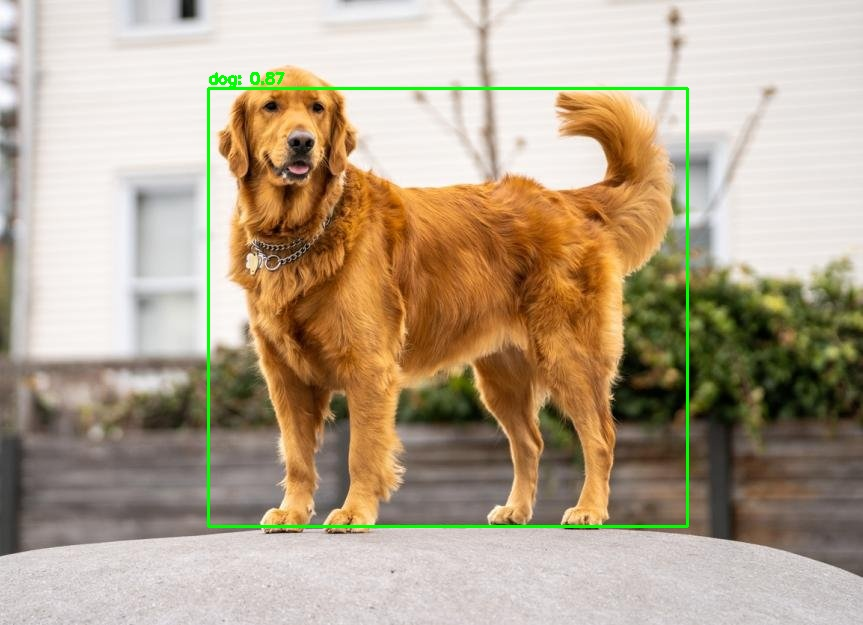

In [13]:
detect('dog.jpeg', 'yolov2.weights')